<a href="https://kaggle.com/code/ritvik1909/siamese-network" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Siamese Network

A Siamese neural network (sometimes called a twin neural network) is an artificial neural network that uses the same weights while working in tandem on two different input vectors to compute comparable output vectors.

Often one of the output vectors is precomputed, thus forming a baseline against which the other output vector is compared. This is similar to comparing fingerprints but can be described more technically as a distance function for locality-sensitive hashing.

It is possible to make a kind of structure that is functional similar to a siamese network, but implements a slightly different function. This is typically used for comparing similar instances in different type sets.

Uses of similarity measures where a twin network might be used are such things as recognizing handwritten checks, automatic detection of faces in camera images, and matching queries with indexed documents. The perhaps most well-known application of twin networks are face recognition, where known images of people are precomputed and compared to an image from a turnstile or similar. It is not obvious at first, but there are two slightly different problems. One is recognizing a person among a large number of other persons, that is the facial recognition problem.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Siamese_neural_network)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, utils, callbacks

Lets start off by creating our dataset. Our input data will be consisting of pairs of images, and output will be either 1 or 0 indicating if the pair are similar or not

In [2]:
def make_pairs(images, labels, seed=19):
    np.random.seed(seed)
    pairImages = []
    pairLabels = []
    
    numClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(numClasses)]

    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]
        
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]
        
        pairImages.append([currentImage, posImage])
        pairLabels.append([1])

        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]
        
        pairImages.append([currentImage, negImage])
        pairLabels.append([0])
    
    return (np.array(pairImages), np.array(pairLabels))        

We will be working with `MNIST` dataset in our notebook which comes along with the tensorflow library

In [3]:
(trainX, trainY), (testX, testY) = mnist.load_data()

trainX = 1 - (trainX / 255.0)
testX  = 1 - (testX / 255.0)

trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

print(f'\nTrain Data Shape: {pairTrain.shape}')
print(f'Test  Data Shape: {pairTest.shape}\n\n')


Train Data Shape: (120000, 2, 28, 28, 1)
Test  Data Shape: (20000, 2, 28, 28, 1)


CPU times: user 16.7 s, sys: 1.45 s, total: 18.1 s
Wall time: 23.9 s


Lets visualize the mnist images

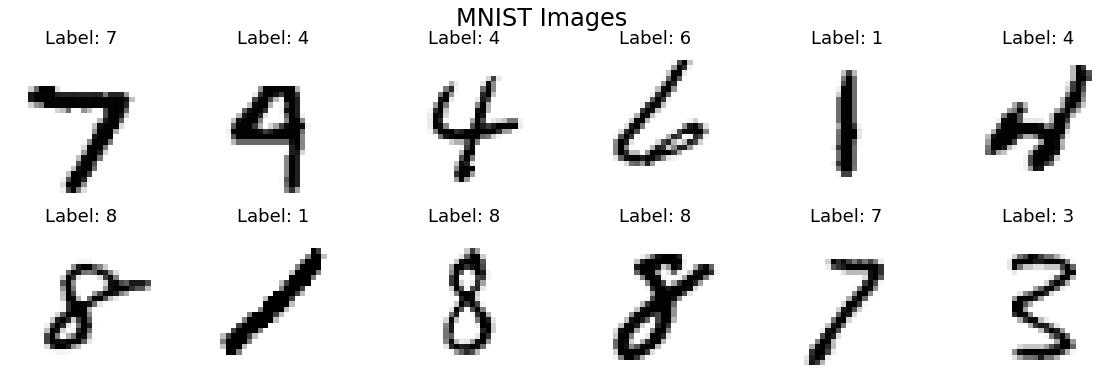

In [4]:
fig, ax = plt.subplots(2, 6, figsize=(20, 6))
random.seed(19)
idx = random.choices(range(len(trainX)), k=12)
for i in range(12):
    ax[i//6][i%6].imshow(np.squeeze(trainX[idx[i]]), cmap='gray')
    ax[i//6][i%6].set_title(f'Label: {trainY[idx[i]]}', fontsize=18)
    ax[i//6][i%6].set_axis_off()
fig.suptitle('MNIST Images', fontsize=24);

Here is a sample of our prepared dataset

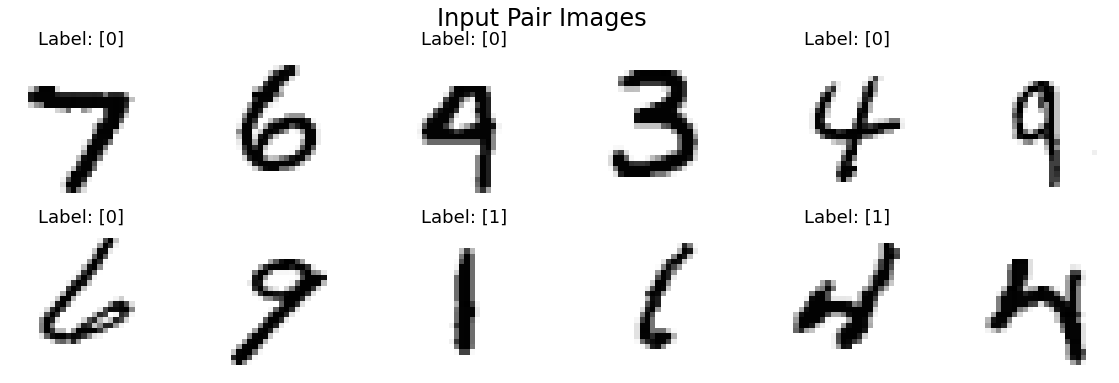

In [5]:
fig, ax = plt.subplots(2, 6, figsize=(20, 6))
random.seed(19)
idx = random.choices(range(len(pairTrain)), k=6)
for i in range(0, 12, 2):
    ax[i//6][i%6].imshow(np.squeeze(pairTrain[idx[i//2]][0]), cmap='gray')
    ax[i//6][i%6+1].imshow(np.squeeze(pairTrain[idx[i//2]][1]), cmap='gray')
    ax[i//6][i%6].set_title(f'Label: {labelTrain[idx[i//2]]}', fontsize=18)
    ax[i//6][i%6].set_axis_off()
    ax[i//6][i%6+1].set_axis_off()
fig.suptitle('Input Pair Images', fontsize=24);

Here we define some configurations for our model

In [6]:
class config():
    IMG_SHAPE = (28, 28, 1)
    EMBEDDING_DIM = 48
    
    BATCH_SIZE = 64
    EPOCHS = 500

Here we define a function to calculate euclidean distance between two vectors. This will be used by our model to calculate the euclidean distance between the vectors of the image pairs (image vectors will be created by the feature extractor of our model)

In [7]:
def euclidean_distance(vectors):
    (featsA, featsB) = vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

With Siamese Network, the two most commonly used loss functions are:
* contrastive loss
* triplet loss

We will be using contrastive loss in this notebook ie:

```Contrastive loss = mean( (1-true_value) * square(prediction) + true_value * square( max(margin - prediction, 0)))```

In [8]:
def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

Finally we define our model architecture

* The model contains two input layers
* A feature extractor through which both the images will be passed to generate feature vectors, the feature extractor typically consists of Convolutional and Pooling Layers
* The feature vectors are passed through a custom layer to get euclidean distance between the vectors
* The final layer consists of a single sigmoid unit

In [9]:
class SiameseNetwork(Model):
    def __init__(self, inputShape, embeddingDim):
        super(SiameseNetwork, self).__init__()
        
        imgA = layers.Input(shape=inputShape)
        imgB = layers.Input(shape=inputShape)
        featureExtractor = self.build_feature_extractor(inputShape, embeddingDim)
        featsA = featureExtractor(imgA)
        featsB = featureExtractor(imgB)
        distance = layers.Lambda(euclidean_distance, name='euclidean_distance')([featsA, featsB])
        outputs = layers.Dense(1, activation="sigmoid")(distance)
        self.model = Model(inputs=[imgA, imgB], outputs=outputs)        
        
    def build_feature_extractor(self, inputShape, embeddingDim=48):

        model = Sequential([
            layers.Input(inputShape),
            layers.Conv2D(64, (2, 2), padding="same", activation="relu"),
            layers.MaxPooling2D(pool_size=2),
            layers.Dropout(0.3),
            layers.Conv2D(64, (2, 2), padding="same", activation="relu"),
            layers.MaxPooling2D(pool_size=2),
            layers.Dropout(0.3),
            layers.Conv2D(128, (1, 1), padding="same", activation="relu"),
            layers.Flatten(),
            layers.Dense(embeddingDim, activation='tanh')
        ])

        return model  
        
    def call(self, x):
        return self.model(x)

model = SiameseNetwork(inputShape=config.IMG_SHAPE, embeddingDim=config.EMBEDDING_DIM)
model.compile(loss=loss(margin=1), optimizer="adam", metrics=["accuracy"])

This is how the model looks like

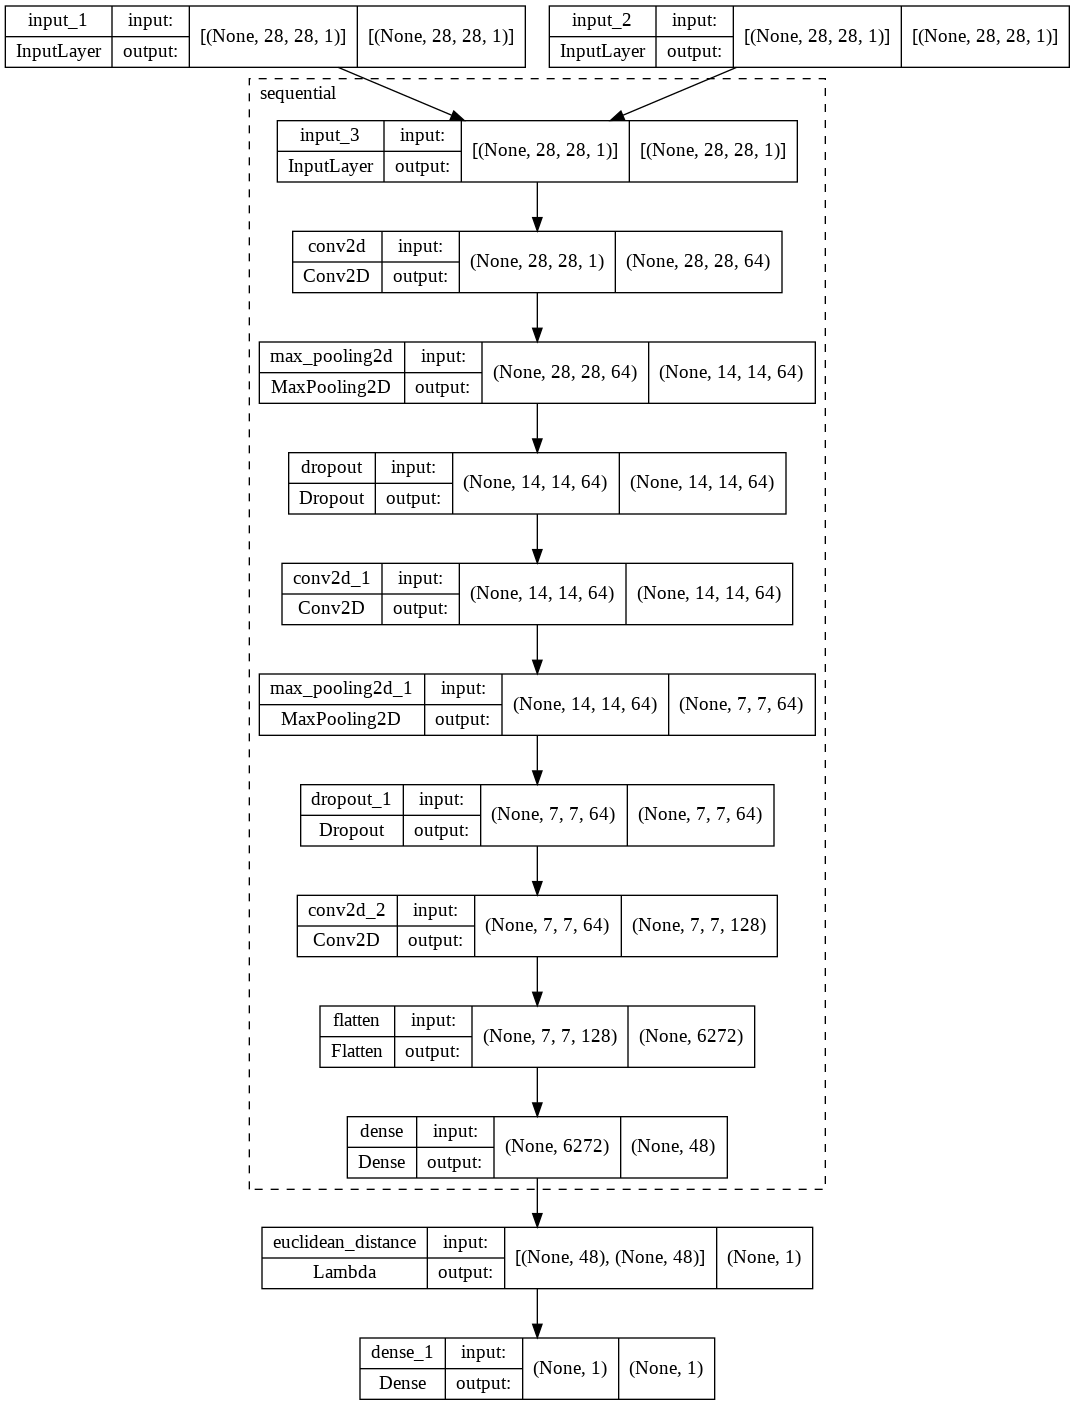

In [10]:
utils.plot_model(model.model, show_shapes=True, expand_nested=True)

In [11]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True, min_delta=1e-4)

rlp = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, mode='min', verbose=1)

history = model.fit(
    [pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
    validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
    batch_size=config.BATCH_SIZE, 
    epochs=config.EPOCHS,
    callbacks=[es, rlp]
)

Epoch 1/500
1875/1875 [==============================] - 17s 8ms/step - loss: 0.1404 - accuracy: 0.7989 - val_loss: 0.0645 - val_accuracy: 0.9389 - lr: 0.0010
Epoch 2/500
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0610 - accuracy: 0.9333 - val_loss: 0.0470 - val_accuracy: 0.9498 - lr: 0.0010
Epoch 3/500
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0500 - accuracy: 0.9429 - val_loss: 0.0420 - val_accuracy: 0.9539 - lr: 0.0010
Epoch 4/500
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0361 - accuracy: 0.9592 - val_loss: 0.0268 - val_accuracy: 0.9708 - lr: 0.0010
Epoch 5/500
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0268 - accuracy: 0.9699 - val_loss: 0.0209 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 6/500
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0240 - accuracy: 0.9723 - val_loss: 0.0205 - val_accuracy: 0.9772 - lr: 0.0010
Epoch 7/500
1875/1875 [=======================

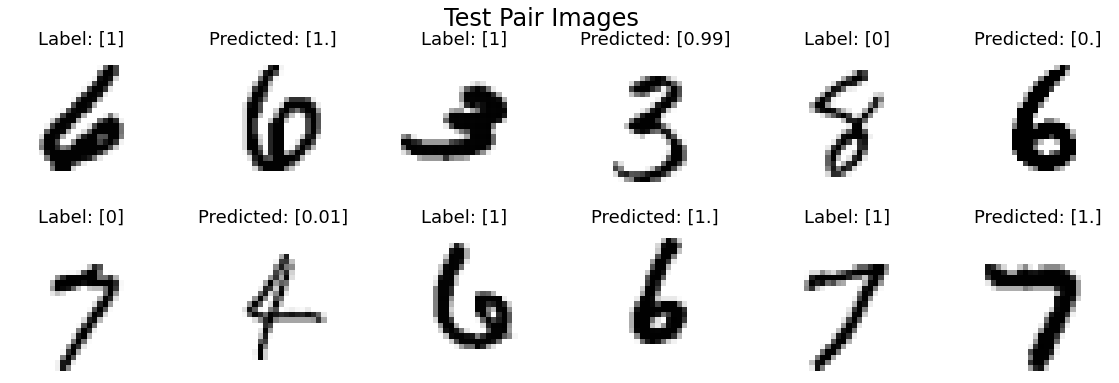

In [12]:
fig, ax = plt.subplots(2, 6, figsize=(20, 6))
random.seed(19)
idx = random.choices(range(len(pairTest)), k=6)
preds = model.predict([pairTest[:, 0], pairTest[:, 1]])
for i in range(0, 12, 2):
    ax[i//6][i%6].imshow(np.squeeze(pairTest[idx[i//2]][0]), cmap='gray')
    ax[i//6][i%6+1].imshow(np.squeeze(pairTest[idx[i//2]][1]), cmap='gray')
    ax[i//6][i%6].set_title(f'Label: {labelTest[idx[i//2]]}', fontsize=18)
    ax[i//6][i%6+1].set_title(f'Predicted: {np.round(preds[idx[i//2]], 2)}', fontsize=18)
    ax[i//6][i%6].set_axis_off()
    ax[i//6][i%6+1].set_axis_off()
fig.suptitle('Test Pair Images', fontsize=24);

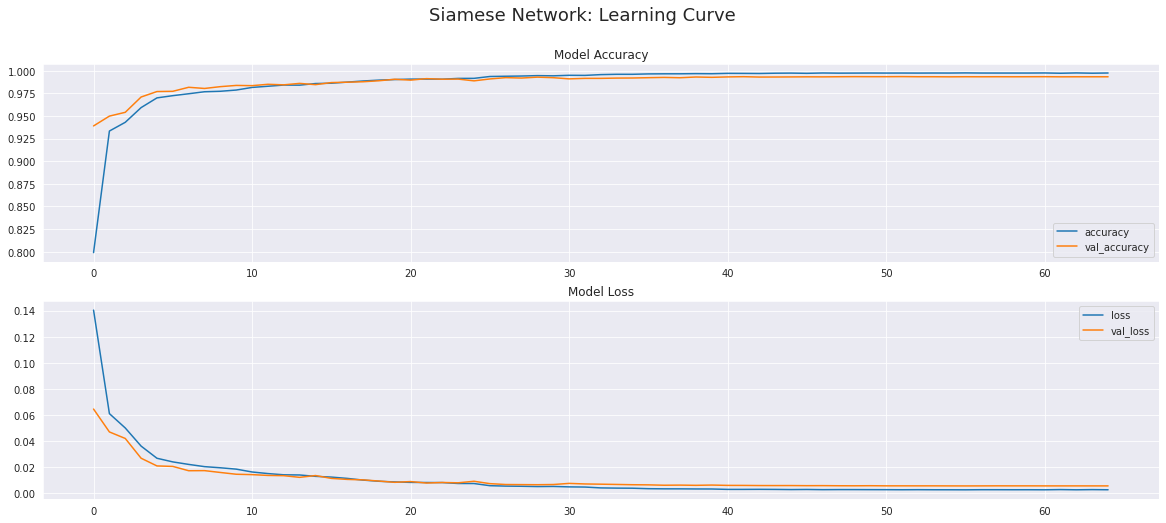

In [13]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Siamese Network: Learning Curve', fontsize=18);

# References
[Fisher Discriminant Triplet and Contrastive Losses for Training Siamese Networks](https://arxiv.org/pdf/2004.04674v1.pdf)